# 🍷 Phân loại loại rượu dựa trên 13 đặc trưng hóa học

- Cấu trúc của bài gồm có các bước sau:
    1. Khám phá và tiền xử lý dữ liệu
    2. Xây dựng mô hình Machine Learning
    3. Huấn luyện và phân tích lỗi
    4. Tối ưu hóa mô hình
    5. Triển khai mô hình
    6. Đánh giá tổng quan và đề xuất cải tiến
- Chi tiết có thể đọc tại [← Quay về README](../README.md)

## Bước 0: Import thư viện cần dùng và thiết lập môi trường
- Các thư viện được khai báo sau đây với mục đích:
    - `pandas`: để xử lý dữ liệu
    - `numpy`: để xử lý mảng
    - `matplotlib`: để vẽ biểu đồ
    - `seaborn`: để vẽ biểu đồ khác với matplotlib là có thể vẽ được biểu đồ phân phối
    - `sklearn`: để chuẩn hóa dữ liệu
    - `warnings`: để ẩn cảnh báo
    - `tabulate`: để hiển thị bảng dữ liệu đẹp hơn

In [207]:
# Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

warnings.filterwarnings('ignore')

- Thiết lập style cho biểu đồ

In [208]:
# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("colorblind")

In [209]:
# Hàm hiển thị nhiều biểu đồ lược đồ cho các đặc trưng
def plot_histograms(df, feature_cols, n_cols=3, bins=20):
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
        for class_value in df['class'].unique():
            sns.histplot(df[df['class'] == class_value][col],
                         bins=bins, kde=True, alpha=0.5,
                         label=f'Class {class_value}', ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    # Ẩn các subplot không sử dụng
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    return fig


In [210]:
# Thiết lập hiển thị đầy đủ
pd.set_option("display.max_columns", None)  # Hiển thị tất cả cột
pd.set_option("display.width", 200)  # Tăng chiều rộng terminal
pd.set_option("display.colheader_justify", "center")  # Căn giữa tiêu đề cột
pd.set_option("display.float_format", "{:,.2f}".format)  # Format số

## Bước 1: Khám phá và tiền xử lý dữ liệu
- Khám phá dữ liệu
 1. Đọc và hiển thị các dòng đầu tiên của dữ liệu
 2. Hiển thị thông tin và cấu trúc dữ liệu
 3. Kiểm tra giá trị null
 4. Phân tích thống kê mô tả (mean, std, min, max, etc.) và đếm số lượng mẫu theo từng lớp
- Tiền xử lý dữ liệu
1. Trực quan hóa dữ liệu (Correlation Heatmap, Histograms, Boxplot)
2. Chuẩn hóa dữ liệu (StandardScaler)
3.

---

### 1.1 Đọc và hiển thị các dòng đầu tiên của dữ liệ


In [270]:
# Đọc tập dữ liệu rượu vang
df = pd.read_csv('Wine-dataset.csv')

In [212]:
# Hiển thị 50 dòng đầu tiên của dữ liệu
print("Hiển thị 50 dòng đầu tiên của dữ liệu:\n")
df.head(50)

Hiển thị 50 dòng đầu tiên của dữ liệu:



,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.60,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.20,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.60,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.80,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.00,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.20,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,1,14.39,1.87,2.45,14.60,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,1,14.06,2.15,2.61,17.60,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,1,14.83,1.64,2.17,14.00,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,1,13.86,1.35,2.27,16.00,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


### 1.2 Hiển thị thông tin và cấu trúc dữ liệu

In [213]:
# Thông tin về kích thước của dữ liệu
print("Số lượng mẫu và số lượng đặc trưng trong dữ liệu:")
df.shape

Số lượng mẫu và số lượng đặc trưng trong dữ liệu:


(178, 14)

In [214]:
# Thông tin về các cột
print("\nThông tin về các cột trong dataset:")
print(df.info())


Thông tin về các cột trong dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   class                         178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wine

### 1.3 Kiểm tra giá trị null

In [215]:
# Kiểm tra giá trị null
print("\nKiểm tra giá trị null trong dataset:")
print(df.isna().sum())


Kiểm tra giá trị null trong dataset:
class                           0
Alcohol                         0
Malic acid                      0
Ash                             0
Alcalinity of ash               0
Magnesium                       0
Total phenols                   0
Flavanoids                      0
Nonflavanoid phenols            0
Proanthocyanins                 0
Color intensity                 0
Hue                             0
OD280/OD315 of diluted wines    0
Proline                         0
dtype: int64


### 1.4 Phân tích thống kê mô tả và đếm số lượng mẫu theo từng lớp

In [216]:
# Thống kê mô tả
print("\nThống kê mô tả của dữ liệu:\n")
print(df.describe().to_string())


Thống kê mô tả của dữ liệu:

       class  Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count 178.00  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00               178.00
mean    1.94   13.00       2.34     2.37        19.49          99.74         2.30          2.03             0.36               1.59             5.06        0.96               2.61               746.89
std     0.78    0.81       1.12     0.27         3.34          14.28         0.63          1.00             0.12               0.57             2.32        0.23               0.71               314.91
min     1.00   11.03       0.74     1.36        10.60          70.00         0.98          0.34             0.13               0.41             1.28        0.48      

In [217]:
# Đếm số lượng mẫu theo từng lớp
print("\nSố lượng mẫu theo từng lớp:")
print(df['class'].value_counts())


Số lượng mẫu theo từng lớp:
class
2    71
1    59
3    48
Name: count, dtype: int64


## 1.4 Trực quan hóa dữ liệu
Trực quan hóa dữ liệu là một bước quan trọng trong phân tích dữ liệu, giúp hiểu rõ hơn về các đặc trưng và mối quan hệ giữa chúng.
- Biểu đồ tương quan (Correlation Heatmap) giữa tất cả các đặc trưng
- Biểu đồ histogram cho mỗi đặc trưng, phân tách theo lớp
- Biểu đồ phân bố số lượng mẫu theo lớp
- Pairplot cho các đặc trưng quan trọng

### 1.4.1 Trực quan hóa phân phối của các đặc trưng
- Sử dụng Correlation Heatmap để trực quan hóa phân phối của các đặc trưng trong tập dữ liệu.

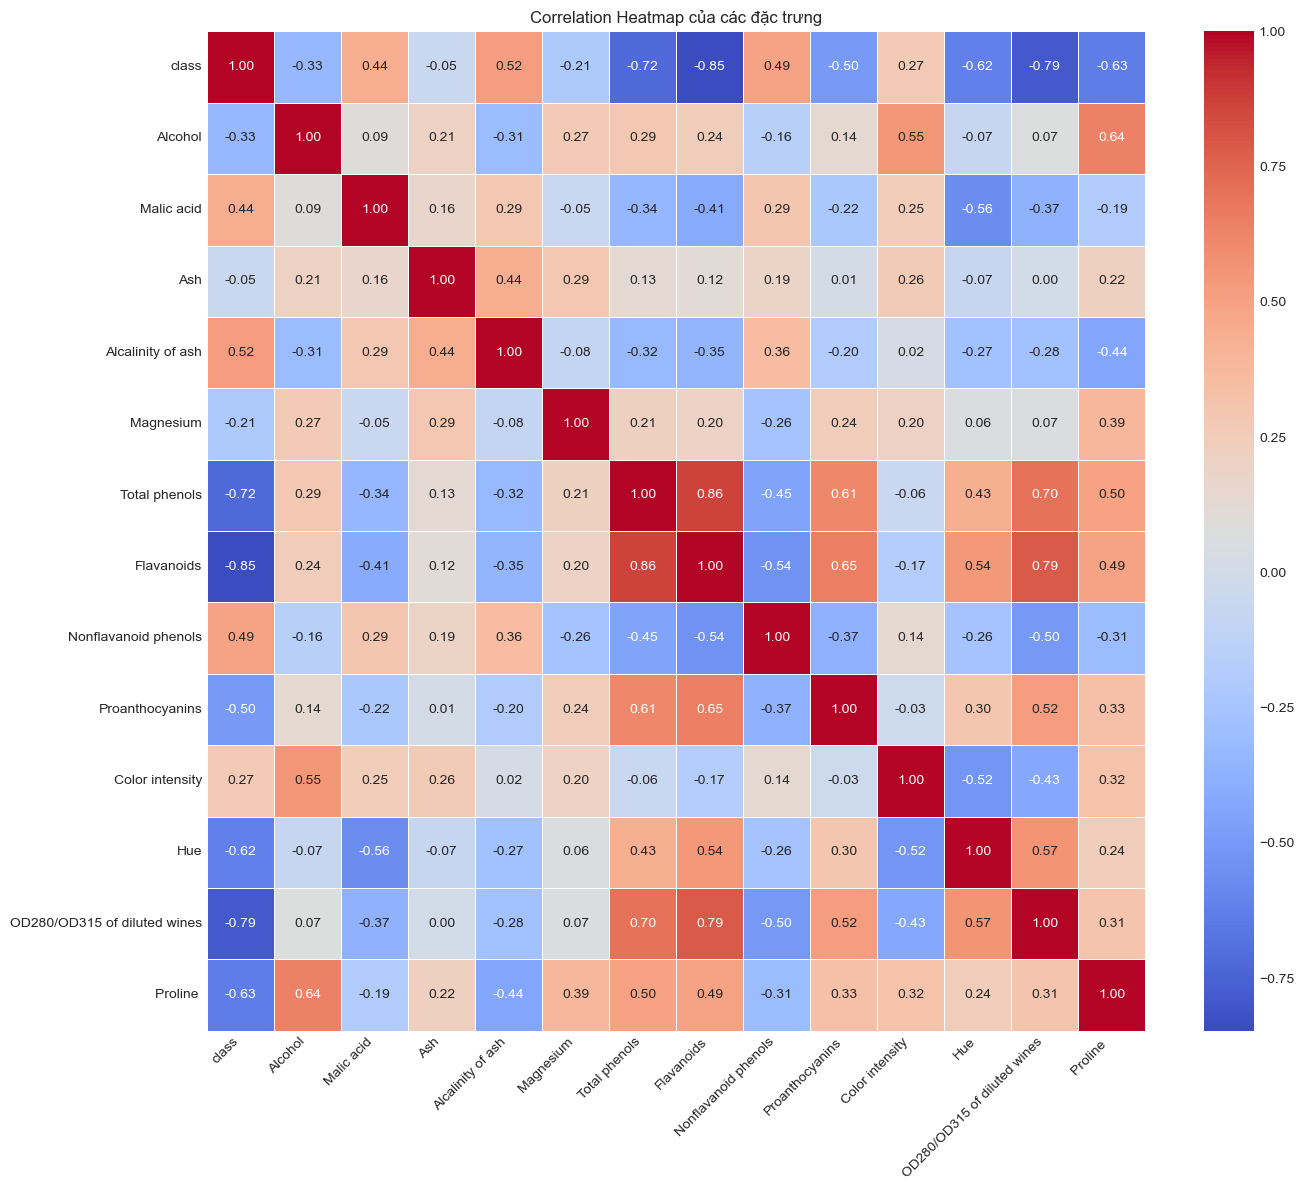

In [218]:
# Biểu đồ tương quan giữa các đặc trưng
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap của các đặc trưng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Sử dụng biểu đồ histogram để trực quan hóa phân phối của các đặc trưng trong tập dữ liệu.

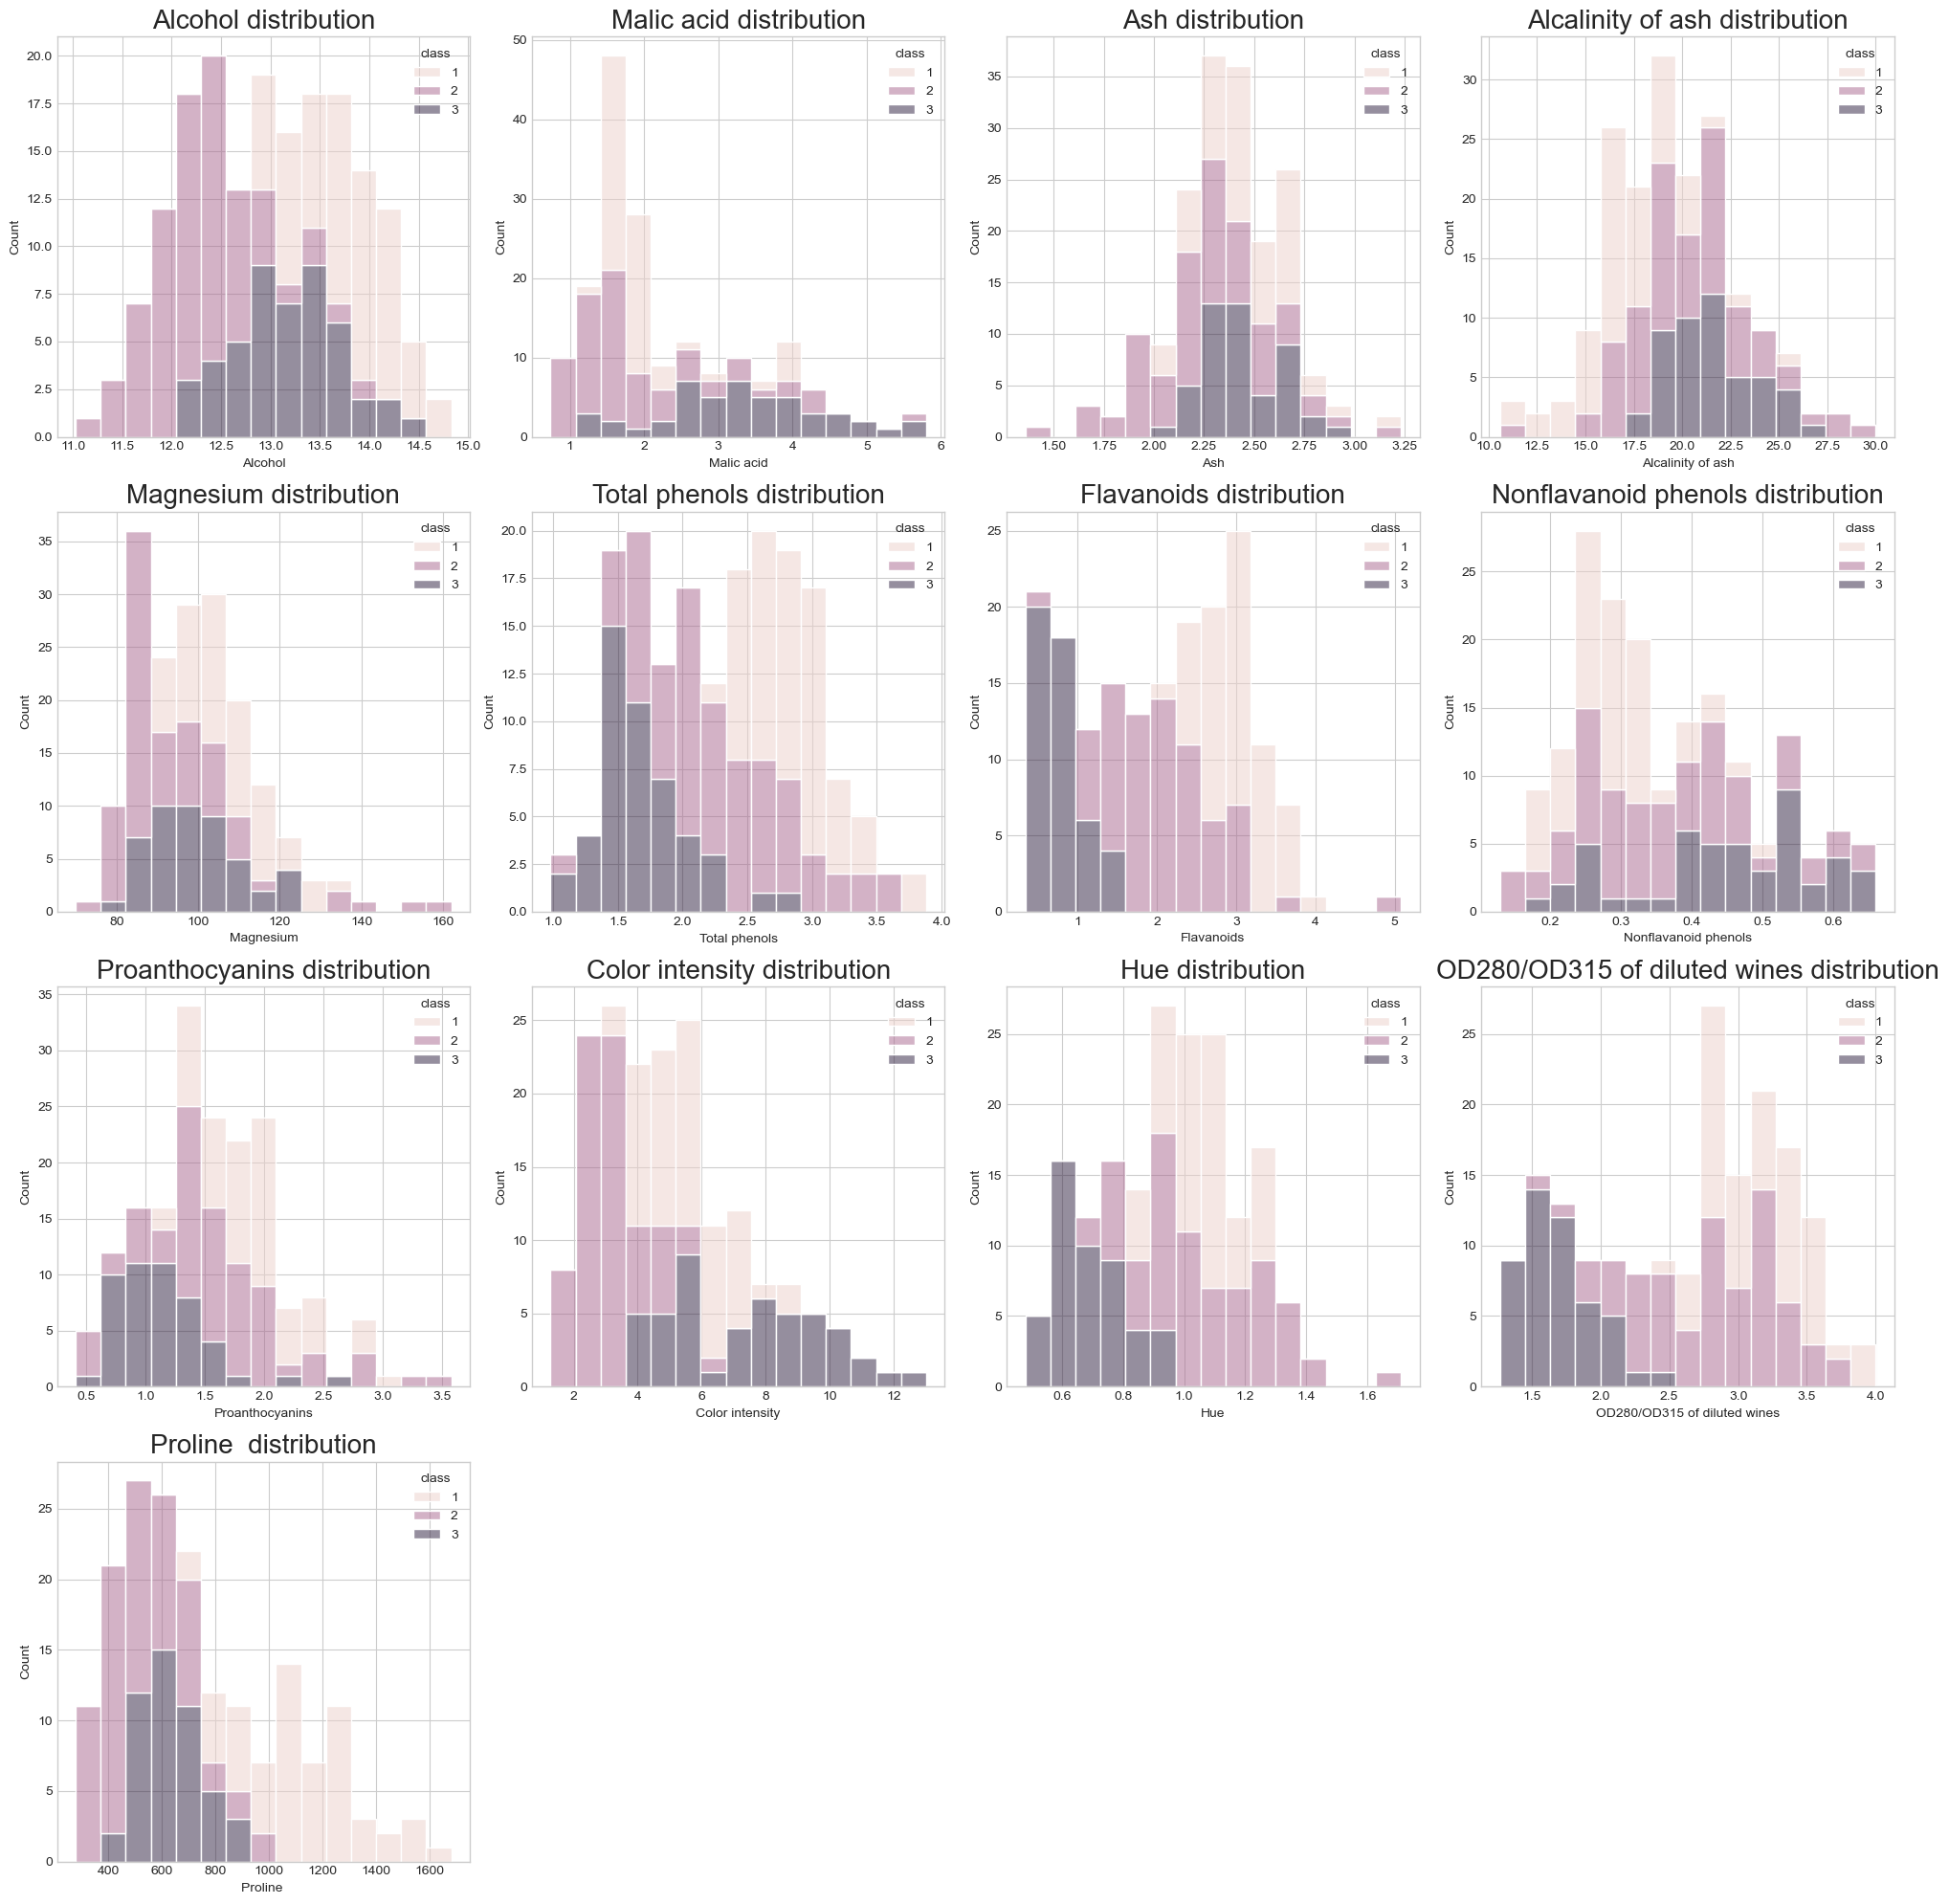

In [219]:
# Vẽ histograms cho các đặc trưng
plt.figure(figsize=(20, 20))
i = 1
for col in df.drop(columns='class'):
    plt.subplot(4, 4, i)
    sns.histplot(data=df, x=col, hue='class', bins=15, multiple="stack", alpha=.5)
    plt.title(col + " distribution", fontsize=20)
    i = i + 1

plt.tight_layout()
plt.show()

- Sử dụng biểu đồ phân bố số lượng mẫu theo lớp để trực quan hóa phân phối của các lớp trong tập dữ liệu.

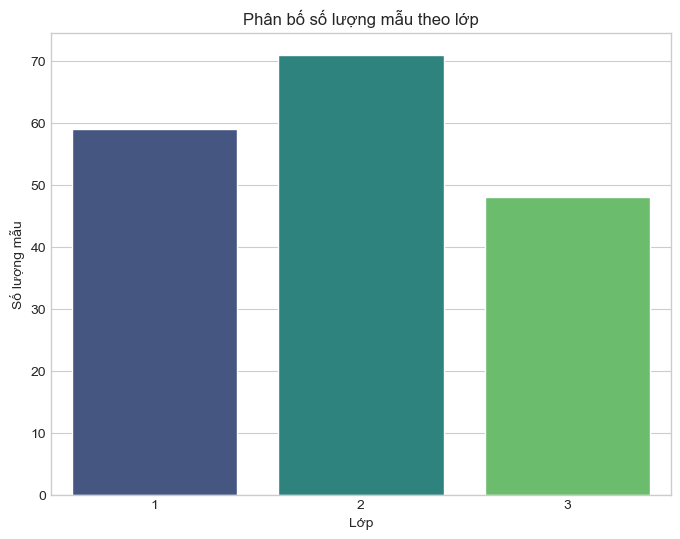

In [220]:
# Biểu đồ phân bố lớp
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette='viridis')
plt.title('Phân bố số lượng mẫu theo lớp')
plt.xlabel('Lớp')
plt.ylabel('Số lượng mẫu')
plt.show()

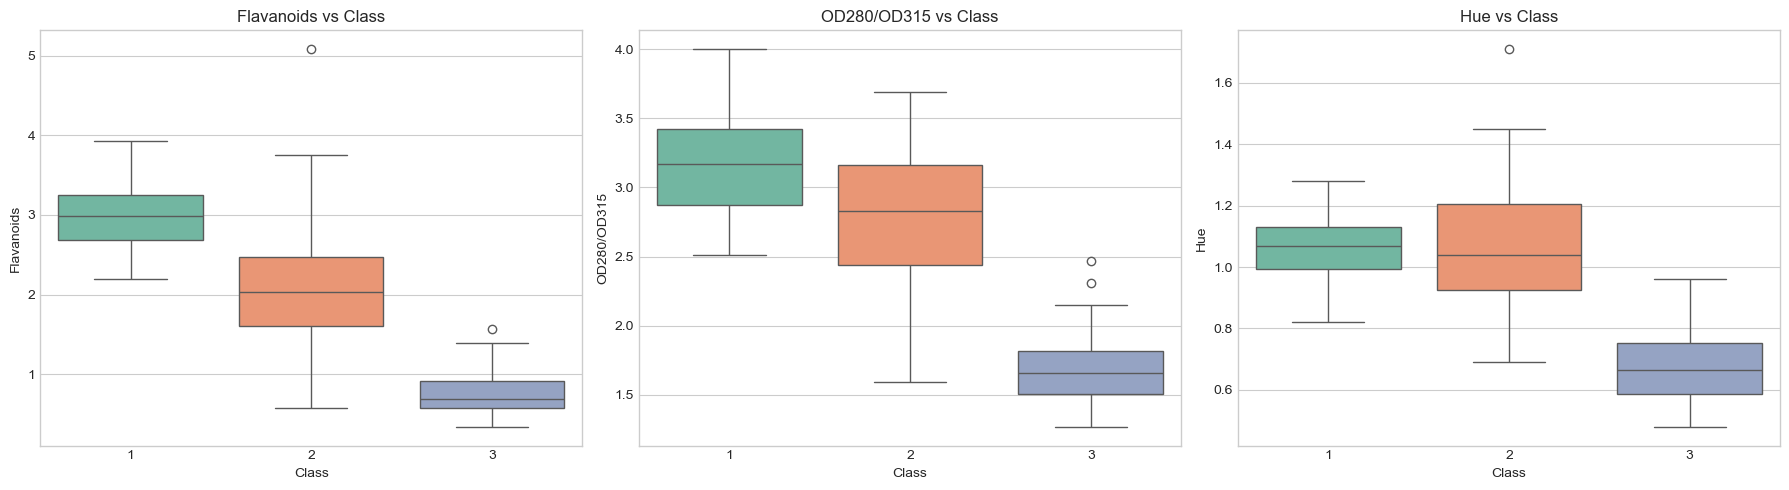

In [221]:
plt.figure(figsize=(18, 5))

# Biểu đồ 1 - Flavanoids
plt.subplot(1, 3, 1)
sns.boxplot(data=df, x="class", y="Flavanoids", palette='Set2')
plt.title("Flavanoids vs Class")
plt.xlabel("Class")
plt.ylabel("Flavanoids")

# Biểu đồ 2 - OD280/OD315
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x="class", y="OD280/OD315 of diluted wines", palette='Set2')
plt.title("OD280/OD315 vs Class")
plt.xlabel("Class")
plt.ylabel("OD280/OD315")

# Biểu đồ 3 - Hue
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x="class", y="Hue", palette='Set2')
plt.title("Hue vs Class")
plt.xlabel("Class")
plt.ylabel("Hue")

# Hiển thị tất cả
plt.tight_layout()
plt.show()

- Sử dụng pairplot để trực quan hóa mối quan hệ giữa các đặc trưng trong tập dữ liệu.

<Figure size 1500x1000 with 0 Axes>

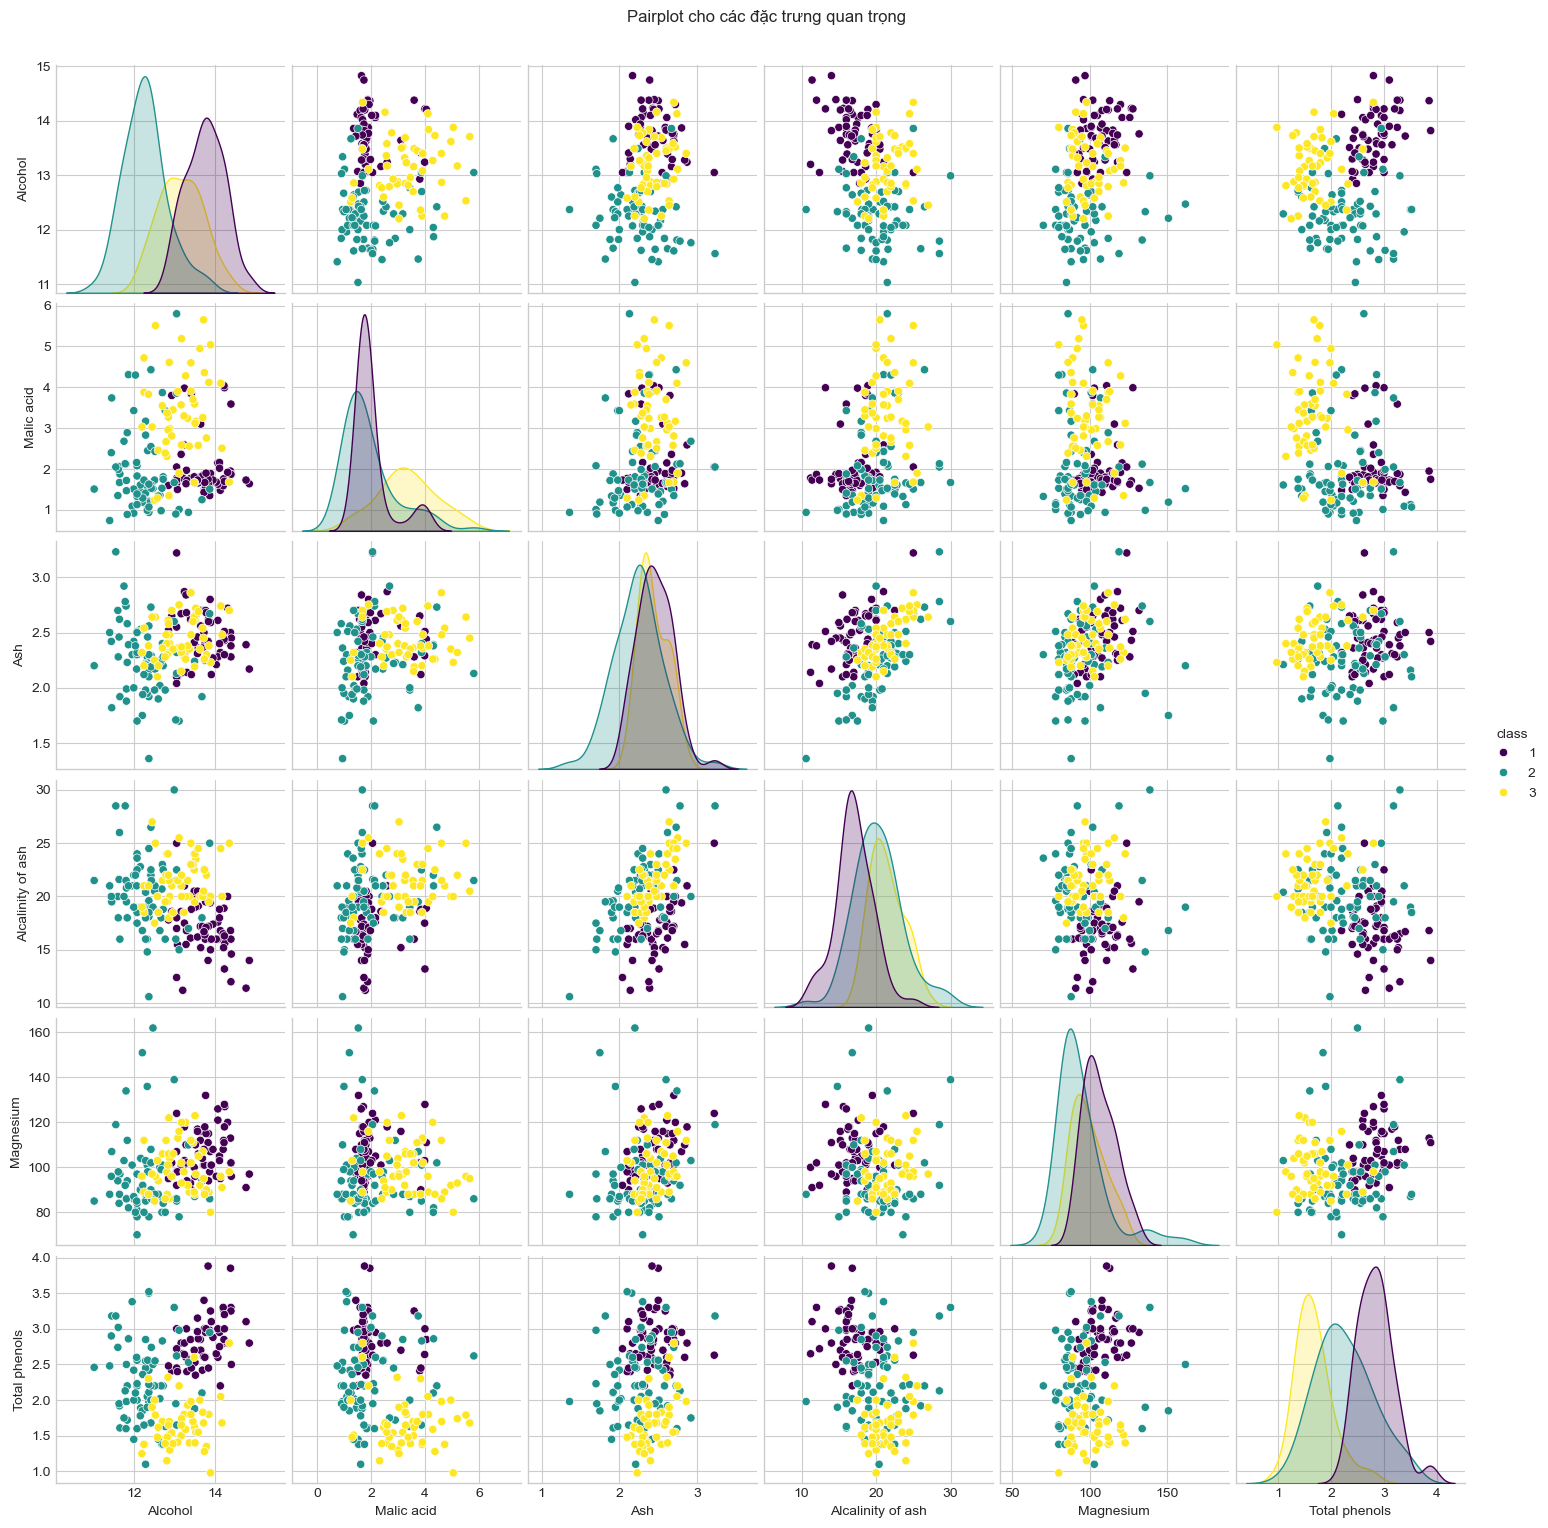

In [222]:
# Pairplot cho một số đặc trưng quan trọng
important_features = ['Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols']
plt.figure(figsize=(15, 10))
sns.pairplot(df, vars=important_features, hue='class', palette='viridis', diag_kind='kde')
plt.suptitle('Pairplot cho các đặc trưng quan trọng', y=1.02)
plt.show()

## 1.5 Tiền xử lý dữ liệu


In [223]:
# Tách đặc trưng và nhãn
X = df.drop('class', axis=1)
y = df['class']

In [224]:
# Kiểm tra xem dữ liệu có cần chuẩn hóa không
# Thống kê mô tả
print("\nThống kê mô tả trước khi chuẩn hóa:\n")
print(X.describe().to_string())


Thống kê mô tả trước khi chuẩn hóa:

       Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00               178.00
mean    13.00       2.34     2.37        19.49          99.74         2.30          2.03             0.36               1.59             5.06        0.96               2.61               746.89
std      0.81       1.12     0.27         3.34          14.28         0.63          1.00             0.12               0.57             2.32        0.23               0.71               314.91
min     11.03       0.74     1.36        10.60          70.00         0.98          0.34             0.13               0.41             1.28        0.48               1.27              

In [225]:
# Chuẩn hóa dữ liệu sử dụng StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [226]:
print("\nThống kê mô tả sau khi chuẩn hóa với StandardScaler:")
print(X_scaled_df.describe())


Thống kê mô tả sau khi chuẩn hóa với StandardScaler:
       Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00              178.00 
mean    -0.00      -0.00    -0.00        -0.00          -0.00         0.00         -0.00             0.00              -0.00             0.00        0.00               0.00               -0.00 
std      1.00       1.00     1.00         1.00           1.00         1.00          1.00             1.00               1.00             1.00        1.00               1.00                1.00 
min     -2.43      -1.43    -3.68        -2.67          -2.09        -2.11         -1.70            -1.87              -2.07            -1.63       -2.09              -1.

In [227]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
min_max_scaler = MinMaxScaler()
X_minmax_scaled = min_max_scaler.fit_transform(X)
X_minmax_scaled_df = pd.DataFrame(X_minmax_scaled, columns=X.columns)


In [228]:
print("\nThống kê mô tả sau khi chuẩn hóa với MinMaxScaler:")
print(X_minmax_scaled_df.describe())


Thống kê mô tả sau khi chuẩn hóa với MinMaxScaler:
       Alcohol  Malic acid   Ash   Alcalinity of ash  Magnesium  Total phenols  Flavanoids  Nonflavanoid phenols  Proanthocyanins  Color intensity   Hue   OD280/OD315 of diluted wines  Proline 
count  178.00     178.00   178.00       178.00         178.00       178.00        178.00           178.00             178.00           178.00      178.00             178.00              178.00 
mean     0.52       0.32     0.54         0.46           0.32         0.45          0.36             0.44               0.37             0.32        0.39               0.49                0.33 
std      0.21       0.22     0.15         0.17           0.16         0.22          0.21             0.23               0.18             0.20        0.19               0.26                0.22 
min      0.00       0.00     0.00         0.00           0.00         0.00          0.00             0.00               0.00             0.00        0.00               0.00

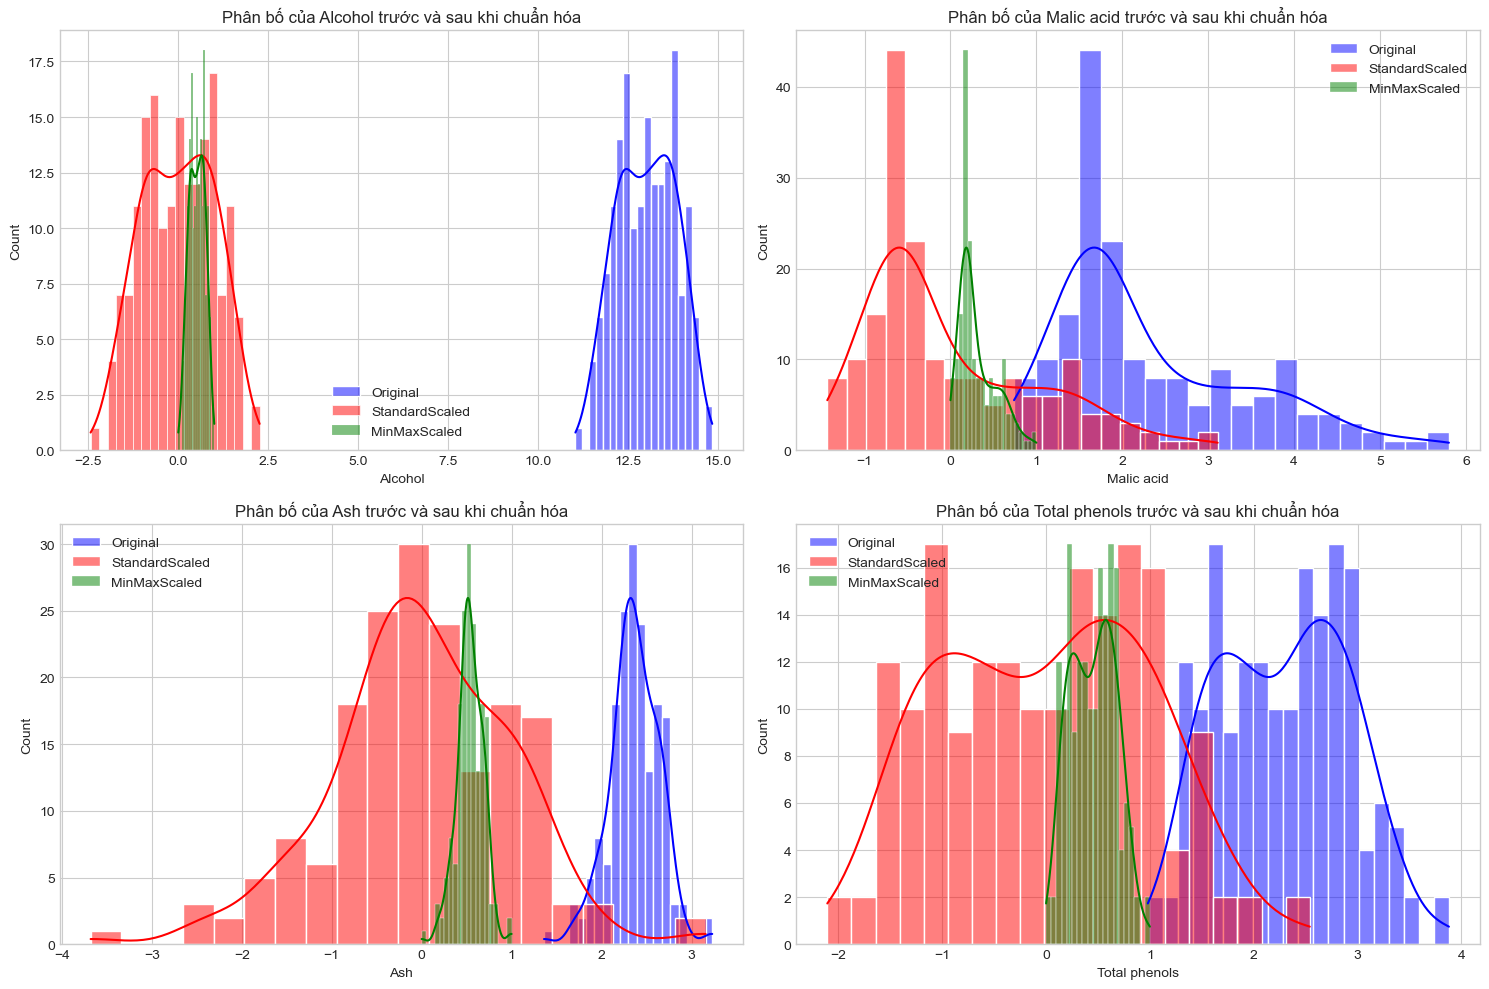

In [229]:
# Visualize một số đặc trưng sau khi chuẩn hóa
plt.figure(figsize=(15, 10))
feature_to_plot = ['Alcohol', 'Malic acid', 'Ash', 'Total phenols']

for i, feature in enumerate(feature_to_plot):
    plt.subplot(2, 2, i + 1)

    # Phân bố dữ liệu gốc
    sns.histplot(X[feature], bins=20, alpha=0.5, color='blue', label='Original', kde=True)

    # Phân bố dữ liệu sau khi chuẩn hóa StandardScaler
    sns.histplot(X_scaled_df[feature], bins=20, alpha=0.5, color='red', label='StandardScaled', kde=True)

    # Phân bố dữ liệu sau khi chuẩn hóa MinMaxScaler
    sns.histplot(X_minmax_scaled_df[feature], bins=20, alpha=0.5, color='green', label='MinMaxScaled', kde=True)

    plt.title(f'Phân bố của {feature} trước và sau khi chuẩn hóa')
    plt.legend()

plt.tight_layout()
plt.show()


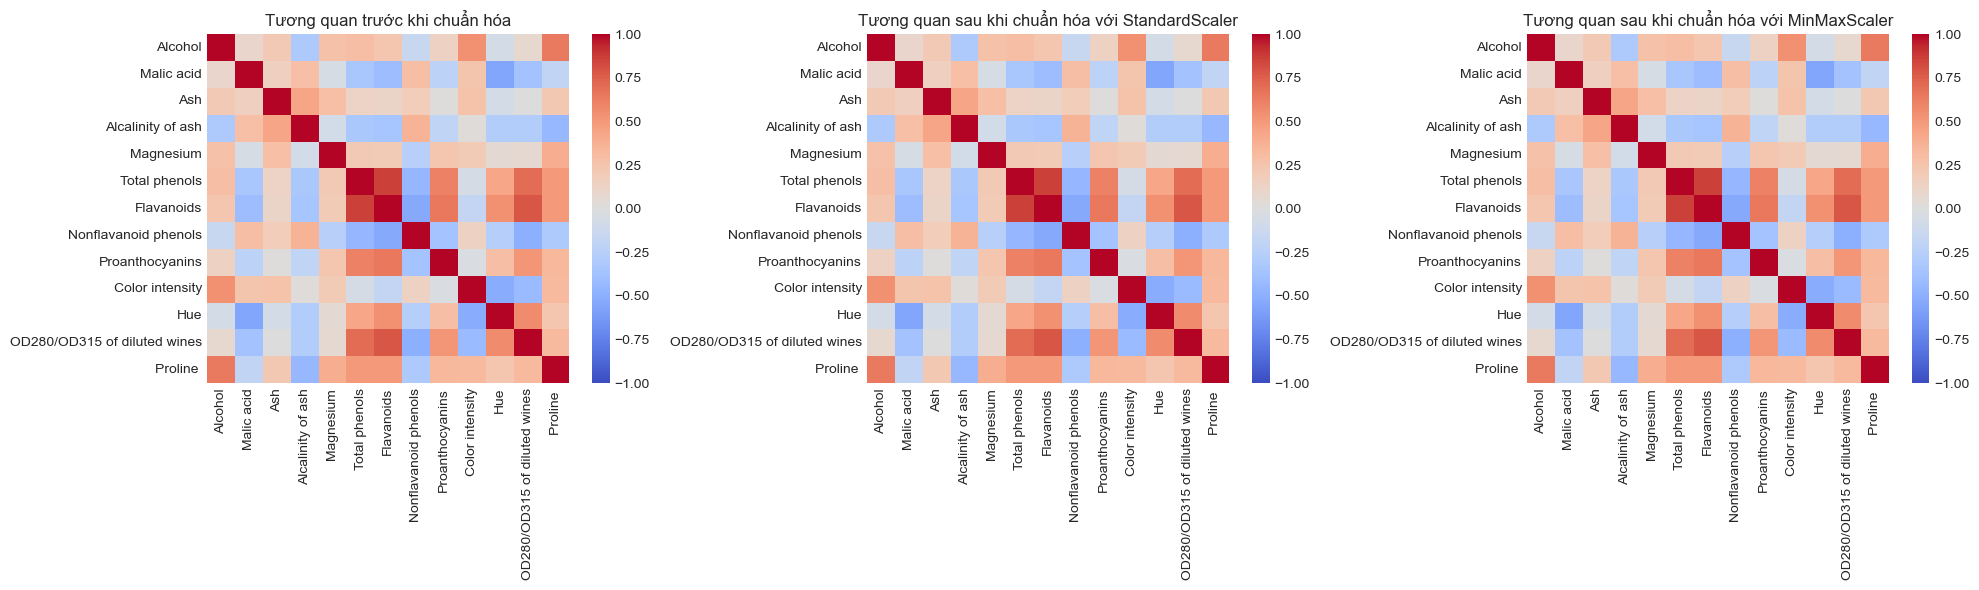


Kết luận và tóm tắt phần khám phá dữ liệu:
1. Dữ liệu không có giá trị null.
2. Dữ liệu có 178 mẫu với 13 đặc trưng.
3. Phân bố các lớp: {2: 71, 1: 59, 3: 48}
4. Chuẩn hóa dữ liệu với StandardScaler hoặc MinMaxScaler không ảnh hưởng đến tương quan giữa các đặc trưng.
5. Một số đặc trưng có tương quan cao với nhau.
6. Sự phân bố của các đặc trưng khác nhau giữa các lớp, cho thấy tiềm năng phân loại cao.


In [230]:
# So sánh tương quan trước và sau khi chuẩn hóa
plt.figure(figsize=(20, 6))

plt.subplot(1, 3, 1)
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Tương quan trước khi chuẩn hóa')

plt.subplot(1, 3, 2)
sns.heatmap(X_scaled_df.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Tương quan sau khi chuẩn hóa với StandardScaler')

plt.subplot(1, 3, 3)
sns.heatmap(X_minmax_scaled_df.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Tương quan sau khi chuẩn hóa với MinMaxScaler')

plt.tight_layout()
plt.show()
print("\nKết luận và tóm tắt phần khám phá dữ liệu:")
print("1. Dữ liệu không có giá trị null.")
print("2. Dữ liệu có", len(df), "mẫu với", len(df.columns) - 1, "đặc trưng.")
print("3. Phân bố các lớp:", df['class'].value_counts().to_dict())
print("4. Chuẩn hóa dữ liệu với StandardScaler hoặc MinMaxScaler không ảnh hưởng đến tương quan giữa các đặc trưng.")
print("5. Một số đặc trưng có tương quan cao với nhau.")
print("6. Sự phân bố của các đặc trưng khác nhau giữa các lớp, cho thấy tiềm năng phân loại cao.")

## 2. Xây dựng mô hình Machine Learning


In [231]:
# Import các thư viện cần thiết cho xây dựng mô hình
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

In [232]:
print("\n\n" + "=" * 50)
print("XÂY DỰNG MÔ HÌNH LOGISTIC REGRESSION VÀ NAIVE BAYES")
print("=" * 50)



XÂY DỰNG MÔ HÌNH LOGISTIC REGRESSION VÀ NAIVE BAYES


In [233]:
# Sử dụng dữ liệu đã chuẩn hóa với StandardScaler
X = X_scaled_df
y = df['class']

In [234]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Số lượng mẫu huấn luyện: {X_train.shape[0]}")
print(f"Số lượng mẫu kiểm tra: {X_test.shape[0]}")
print(f"Phân bố lớp trong tập huấn luyện: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Phân bố lớp trong tập kiểm tra: {pd.Series(y_test).value_counts().to_dict()}")

Số lượng mẫu huấn luyện: 142
Số lượng mẫu kiểm tra: 36
Phân bố lớp trong tập huấn luyện: {2: 57, 1: 47, 3: 38}
Phân bố lớp trong tập kiểm tra: {2: 14, 1: 12, 3: 10}


## 2.1 Xây dựng mô hình Logistic Regression


In [235]:
print("\n--- Mô hình Logistic Regression ---")
# Thiết lập mô hình Logistic Regression với các tham số đã chỉ định
lr_model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)


--- Mô hình Logistic Regression ---


In [236]:
# Huấn luyện mô hình trên tập huấn luyện
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [237]:
# Dự đoán trên tập kiểm tra
y_pred_lr = lr_model.predict(X_test)

Đánh giá mô hình Logistic Regression:
Accuracy: 0.9722

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.93      1.00      0.97        14
           3       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36


Ma trận nhầm lẫn:


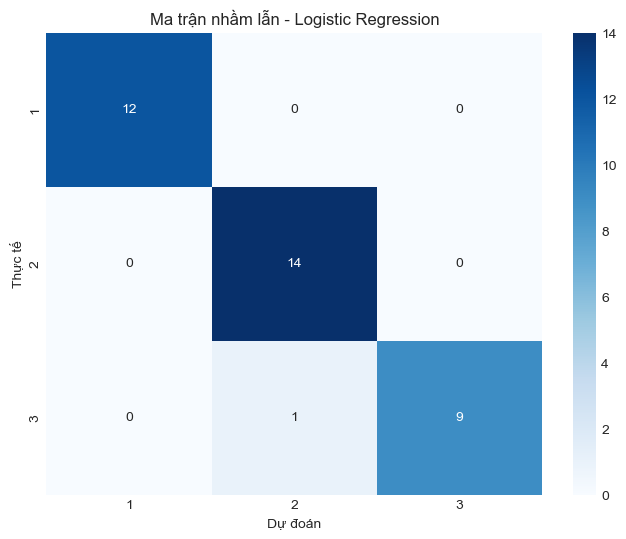

In [238]:
# Đánh giá mô hình
print("Đánh giá mô hình Logistic Regression:")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy: {lr_accuracy:.4f}")

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_lr))

print("\nMa trận nhầm lẫn:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['class'].unique()),
            yticklabels=sorted(df['class'].unique()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Logistic Regression')
plt.show()

In [239]:
# Đánh giá chéo (Cross-validation)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results_lr = cross_val_score(lr_model, X, y, cv=kfold, scoring='accuracy')
print(f"\nĐộ chính xác trung bình qua 5-fold cross-validation: {cv_results_lr.mean():.4f} ± {cv_results_lr.std():.4f}")


Độ chính xác trung bình qua 5-fold cross-validation: 0.9887 ± 0.0138


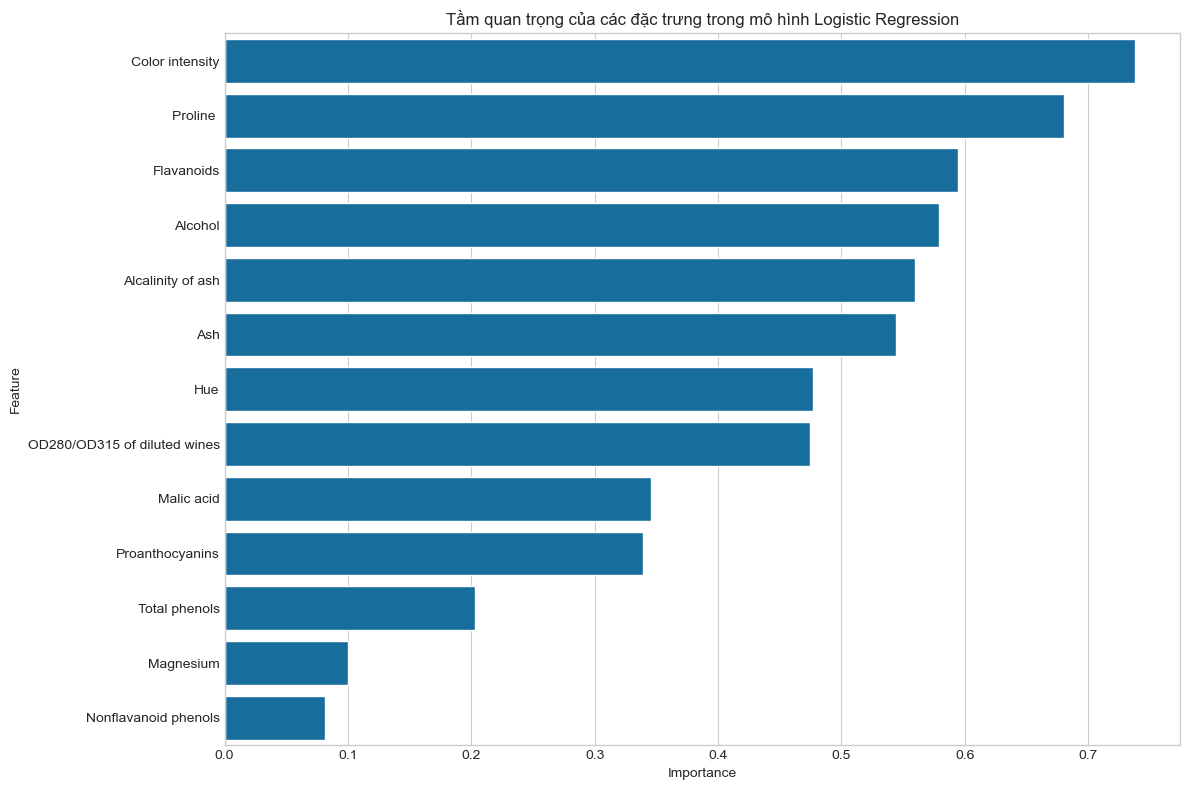

In [240]:
# Hiển thị hệ số của mô hình
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(lr_model.coef_).mean(axis=0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Tầm quan trọng của các đặc trưng trong mô hình Logistic Regression')
plt.tight_layout()
plt.show()

## 2.2 Xây dựng mô hình Naive Bayes


In [241]:
print("\n--- Mô hình Naive Bayes ---")
# Thiết lập mô hình Gaussian Naive Bayes
nb_model = GaussianNB()


--- Mô hình Naive Bayes ---


In [242]:
# Huấn luyện mô hình trên tập huấn luyện
nb_model.fit(X_train, y_train)

GaussianNB()

In [243]:
# Dự đoán trên tập kiểm tra
y_pred_nb = nb_model.predict(X_test)

Đánh giá mô hình Naive Bayes:
Accuracy: 0.9722

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36


Ma trận nhầm lẫn:


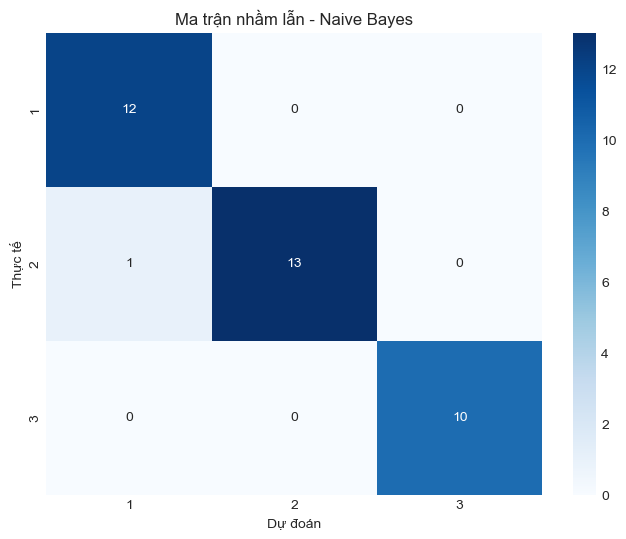

In [244]:
# Đánh giá mô hình
print("Đánh giá mô hình Naive Bayes:")
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Accuracy: {nb_accuracy:.4f}")

print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_nb))

print("\nMa trận nhầm lẫn:")
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(df['class'].unique()),
            yticklabels=sorted(df['class'].unique()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Naive Bayes')
plt.show()

In [245]:
# Đánh giá chéo (Cross-validation)
cv_results_nb = cross_val_score(nb_model, X, y, cv=kfold, scoring='accuracy')
print(f"\nĐộ chính xác trung bình qua 5-fold cross-validation: {cv_results_nb.mean():.4f} ± {cv_results_nb.std():.4f}")


Độ chính xác trung bình qua 5-fold cross-validation: 0.9830 ± 0.0228


## 2.3 So sánh hiệu suất của hai mô hình


In [246]:
print("\n--- So sánh hiệu suất của hai mô hình ---")
models = ['Logistic Regression', 'Naive Bayes']
accuracies = [lr_accuracy, nb_accuracy]
cv_means = [cv_results_lr.mean(), cv_results_nb.mean()]
cv_stds = [cv_results_lr.std(), cv_results_nb.std()]


--- So sánh hiệu suất của hai mô hình ---


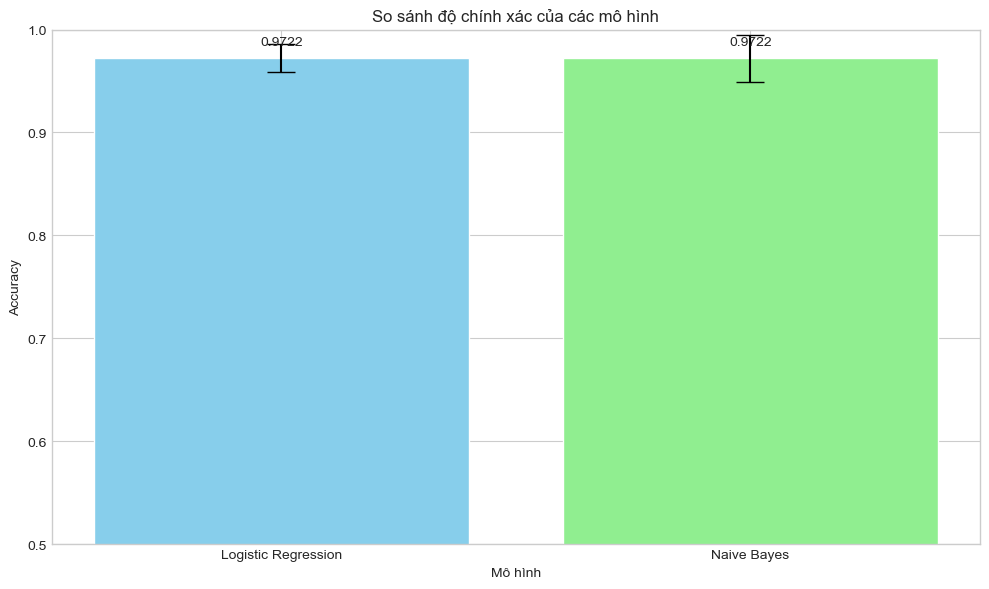

In [247]:
# Vẽ biểu đồ so sánh accuracy
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, yerr=cv_stds, capsize=10, color=['skyblue', 'lightgreen'])
plt.ylim(0.5, 1.0)
plt.xlabel('Mô hình')
plt.ylabel('Accuracy')
plt.title('So sánh độ chính xác của các mô hình')

# Thêm giá trị accuracy lên biểu đồ
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

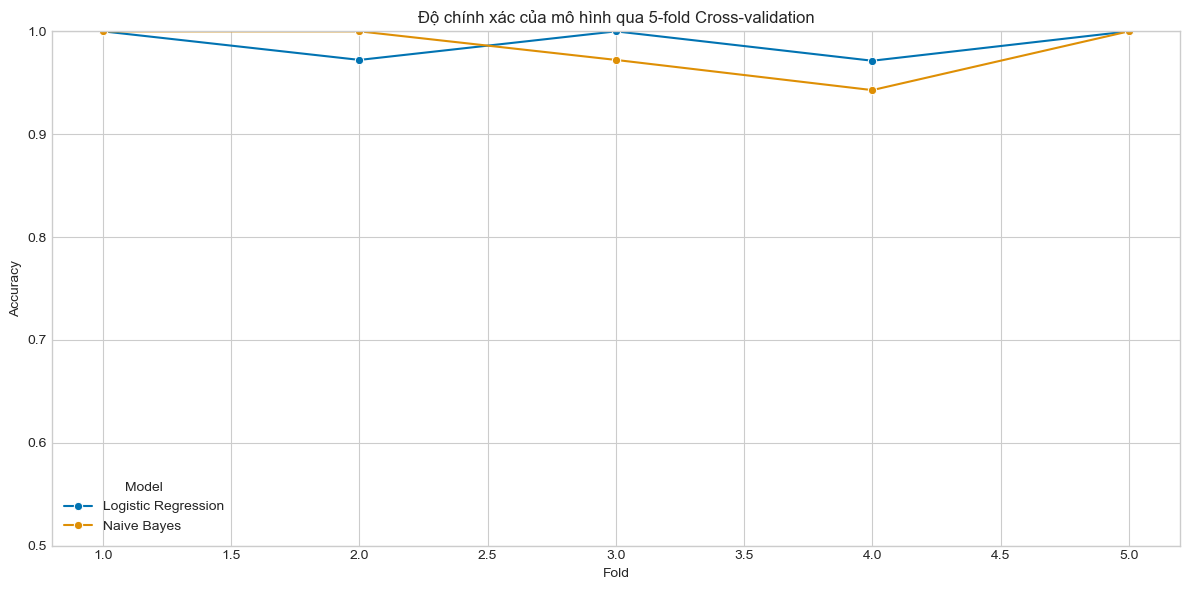


Kết luận và tóm tắt về mô hình:
1. Mô hình Logistic Regression đạt accuracy: 0.9722 (CV: 0.9887 ± 0.0138)
2. Mô hình Naive Bayes đạt accuracy: 0.9722 (CV: 0.9830 ± 0.0228)
3. Cả hai mô hình cho kết quả tương đương nhau trên tập test.
4. Logistic Regression có độ ổn định tốt hơn qua cross-validation.


In [248]:
# Vẽ biểu đồ so sánh cross-validation
plt.figure(figsize=(12, 6))
cv_data = pd.DataFrame({
    'Model': np.repeat(models, 5),
    'Fold': np.tile(range(1, 6), 2),
    'Accuracy': np.concatenate([cv_results_lr, cv_results_nb])
})

sns.lineplot(x='Fold', y='Accuracy', hue='Model', data=cv_data, marker='o')
plt.title('Độ chính xác của mô hình qua 5-fold Cross-validation')
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nKết luận và tóm tắt về mô hình:")
print(
    f"1. Mô hình Logistic Regression đạt accuracy: {lr_accuracy:.4f} (CV: {cv_results_lr.mean():.4f} ± {cv_results_lr.std():.4f})")
print(
    f"2. Mô hình Naive Bayes đạt accuracy: {nb_accuracy:.4f} (CV: {cv_results_nb.mean():.4f} ± {cv_results_nb.std():.4f})")

if lr_accuracy > nb_accuracy:
    print("3. Logistic Regression cho kết quả tốt hơn Naive Bayes trên tập test.")
elif nb_accuracy > lr_accuracy:
    print("3. Naive Bayes cho kết quả tốt hơn Logistic Regression trên tập test.")
else:
    print("3. Cả hai mô hình cho kết quả tương đương nhau trên tập test.")

if cv_results_lr.mean() > cv_results_nb.mean():
    print("4. Logistic Regression có độ ổn định tốt hơn qua cross-validation.")
elif cv_results_nb.mean() > cv_results_lr.mean():
    print("4. Naive Bayes có độ ổn định tốt hơn qua cross-validation.")
else:
    print("4. Cả hai mô hình có độ ổn định tương đương qua cross-validation.")

In [249]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42, stratify=y)

# Bước 3: Đánh giá mô hình theo F1-Score


In [250]:
# Tạo các mô hình cơ bản
lr_model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=42, max_iter=1000)
nb_model = GaussianNB()

# Đánh giá theo F1-Score
models = {
    "Logistic Regression": lr_model,
    "Naive Bayes": nb_model
}

In [251]:
# Đánh giá trên tập test
results_f1 = {}
for name, model in models.items():
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)

    # Tính F1-Score (weighted để xử lý không cân bằng)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results_f1[name] = f1

    print(f"\n--- Model: {name} ---")
    print(f"F1-Score (weighted): {f1:.4f}")
    print("\nBáo cáo phân loại:")
    print(classification_report(y_test, y_pred))


--- Model: Logistic Regression ---
F1-Score (weighted): 0.9720

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       0.93      1.00      0.97        14
           3       1.00      0.90      0.95        10

    accuracy                           0.97        36
   macro avg       0.98      0.97      0.97        36
weighted avg       0.97      0.97      0.97        36


--- Model: Naive Bayes ---
F1-Score (weighted): 0.9723

Báo cáo phân loại:
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



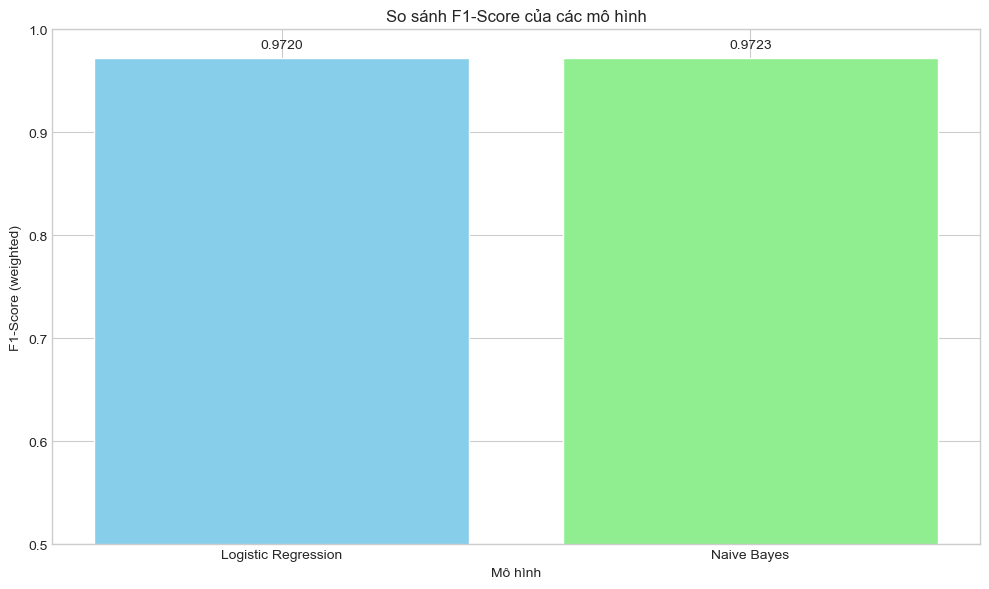

In [252]:
# Vẽ biểu đồ so sánh F1-Score
plt.figure(figsize=(10, 6))
plt.bar(results_f1.keys(), results_f1.values(), color=['skyblue', 'lightgreen'])
plt.ylim(0.5, 1.0)
plt.xlabel('Mô hình')
plt.ylabel('F1-Score (weighted)')
plt.title('So sánh F1-Score của các mô hình')

# Thêm giá trị F1-Score lên biểu đồ
for i, (name, f1) in enumerate(results_f1.items()):
    plt.text(i, f1 + 0.01, f"{f1:.4f}", ha='center')

plt.tight_layout()
plt.show()

In [253]:
# Kiểm tra Cross-validation với F1-Score
cv_results_f1 = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    cv_f1 = cross_val_score(model, X_scaled_df, y, cv=kfold, scoring='f1_weighted')
    cv_results_f1[name] = (cv_f1.mean(), cv_f1.std())
    print(f"\n{name} - F1-Score qua 5-fold CV: {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")


Logistic Regression - F1-Score qua 5-fold CV: 0.9888 ± 0.0138

Naive Bayes - F1-Score qua 5-fold CV: 0.9830 ± 0.0228


# Bước 4: Tối ưu hóa mô hình


In [254]:
# Pipeline để kết hợp tiền xử lý và mô hình
pipe_lr = Pipeline([
    ('classifier', LogisticRegression(random_state=42, max_iter=2000))
])

In [255]:
# Tham số cần tìm kiếm
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [256]:
# Grid Search để tìm tham số tối ưu
grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Huấn luyện và tìm tham số tối ưu
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=2000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='f1_weighted', verbose=1)

In [257]:
# Hiển thị kết quả
print(f"\nTham số tốt nhất cho Logistic Regression: {grid_lr.best_params_}")
print(f"F1-Score tốt nhất trên tập validation: {grid_lr.best_score_:.4f}")

# Sử dụng mô hình tốt nhất để dự đoán
best_lr = grid_lr.best_estimator_
y_pred_lr_best = best_lr.predict(X_test)
lr_best_f1 = f1_score(y_test, y_pred_lr_best, average='weighted')

print("\nKết quả trên tập test với mô hình Logistic Regression tốt nhất:")
print(f"F1-Score: {lr_best_f1:.4f}")
print(classification_report(y_test, y_pred_lr_best))


Tham số tốt nhất cho Logistic Regression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
F1-Score tốt nhất trên tập validation: 0.9932

Kết quả trên tập test với mô hình Logistic Regression tốt nhất:
F1-Score: 1.0000
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



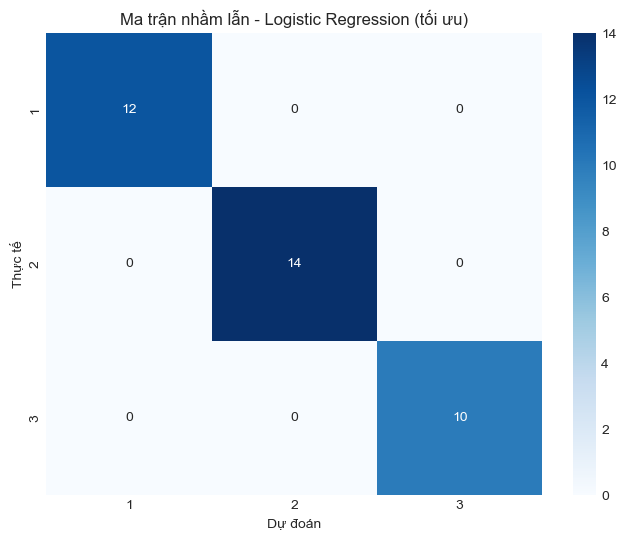

In [258]:
# Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm_lr_best = confusion_matrix(y_test, y_pred_lr_best)
sns.heatmap(cm_lr_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['class'].unique()),
            yticklabels=sorted(df['class'].unique()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Logistic Regression (tối ưu)')
plt.show()

In [259]:
# Phân tích Naive Bayes
print("\n--- Phân tích Naive Bayes ---")
print("GaussianNB không có nhiều tham số để tối ưu hóa.")
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_f1 = f1_score(y_test, y_pred_nb, average='weighted')

print("\nKết quả trên tập test với mô hình Naive Bayes:")
print(f"F1-Score: {nb_f1:.4f}")
print(classification_report(y_test, y_pred_nb))


--- Phân tích Naive Bayes ---
GaussianNB không có nhiều tham số để tối ưu hóa.

Kết quả trên tập test với mô hình Naive Bayes:
F1-Score: 0.9723
              precision    recall  f1-score   support

           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14
           3       1.00      1.00      1.00        10

    accuracy                           0.97        36
   macro avg       0.97      0.98      0.97        36
weighted avg       0.97      0.97      0.97        36



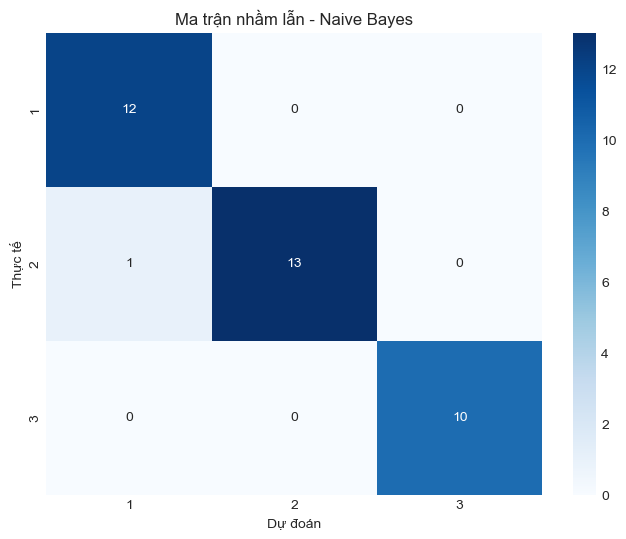

In [260]:
# Ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df['class'].unique()),
            yticklabels=sorted(df['class'].unique()))
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Naive Bayes')
plt.show()


--- So sánh kết quả sau tối ưu hóa ---


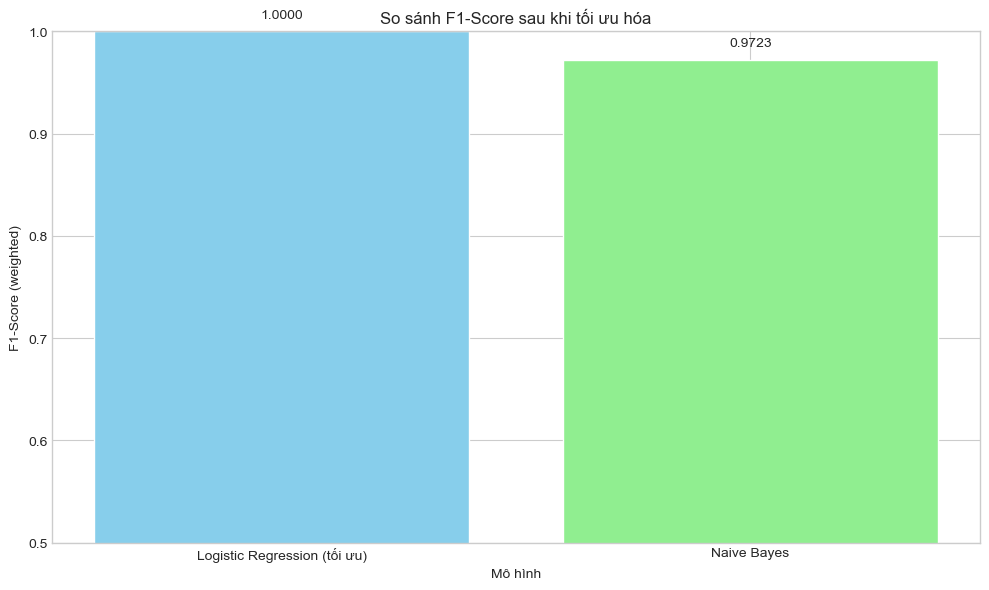

In [261]:
# So sánh kết quả sau khi tối ưu hóa
print("\n--- So sánh kết quả sau tối ưu hóa ---")
models_optimized = ['Logistic Regression (tối ưu)', 'Naive Bayes']
f1_scores = [lr_best_f1, nb_f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(models_optimized, f1_scores, color=['skyblue', 'lightgreen'])
plt.ylim(0.5, 1.0)
plt.xlabel('Mô hình')
plt.ylabel('F1-Score (weighted)')
plt.title('So sánh F1-Score sau khi tối ưu hóa')

# Thêm giá trị F1-Score lên biểu đồ
for bar, f1 in zip(bars, f1_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
             f'{f1:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [262]:
# Lưu các mô hình tốt nhất
import joblib

# BƯỚC 5: TRIỂN KHAI MÔ HÌNH

In [263]:
# Lưu mô hình Logistic Regression tốt nhất
joblib.dump(best_lr, 'best_logistic_regression_model.pkl')

# Lưu mô hình Naive Bayes
joblib.dump(nb_model, 'naive_bayes_model.pkl')

# Lưu bộ StandardScaler để sử dụng khi dự đoán mẫu mới
joblib.dump(scaler, 'standard_scaler.pkl')

print("\nĐã lưu các mô hình vào file:")
print("- best_logistic_regression_model.pkl")
print("- naive_bayes_model.pkl")
print("- standard_scaler.pkl")


Đã lưu các mô hình vào file:
- best_logistic_regression_model.pkl
- naive_bayes_model.pkl
- standard_scaler.pkl


In [264]:
print("\nDemo chương trình dự đoán mẫu mới:")
print("=" * 50)


def predict_wine_class(features, model_name='logistic'):
    """
    Dự đoán lớp rượu dựa trên các đặc trưng đầu vào

    Parameters:
    -----------
    features : list
        Danh sách các đặc trưng của mẫu rượu theo thứ tự trong tập dữ liệu
    model_name : str, mặc định 'logistic'
        Tên mô hình sử dụng để dự đoán ('logistic' hoặc 'naive_bayes')

    Returns:
    --------
    int
        Lớp dự đoán của mẫu rượu
    """
    # Tải bộ scaler
    loaded_scaler = joblib.load('standard_scaler.pkl')

    # Chuyển features thành mảng numpy và reshape
    features_array = np.array(features).reshape(1, -1)

    # Chuẩn hóa đặc trưng
    features_scaled = loaded_scaler.transform(features_array)

    # Tải mô hình phù hợp
    if model_name.lower() == 'logistic':
        loaded_model = joblib.load('best_logistic_regression_model.pkl')
    elif model_name.lower() == 'naive_bayes':
        loaded_model = joblib.load('naive_bayes_model.pkl')
    else:
        raise ValueError("model_name phải là 'logistic' hoặc 'naive_bayes'")

    # Dự đoán lớp
    predicted_class = loaded_model.predict(features_scaled)[0]

    return predicted_class


# Demo dự đoán với mẫu từ tập test
sample_idx = 10  # Chọn một mẫu từ tập test
sample_features = X_test.iloc[sample_idx].values.tolist()
true_class = y_test.iloc[sample_idx]

print(f"Đặc trưng mẫu:\n{sample_features}")
print(f"Lớp thực tế: {true_class}")



Demo chương trình dự đoán mẫu mới:
Đặc trưng mẫu:
[-0.8160382429050576, 0.10202092941239642, 0.34171276833208214, 0.4519457833385772, -0.12228166064446651, 0.4244378230432925, 0.08105057191005977, -0.17609475049050788, -0.49215846354084397, -0.9767819017927332, -0.6907840159909726, 1.0852004462188667, -0.983668647358287]
Lớp thực tế: 2


In [265]:
# Dự đoán với cả hai mô hình
lr_pred = predict_wine_class(sample_features, 'logistic')
nb_pred = predict_wine_class(sample_features, 'naive_bayes')

print(f"Dự đoán của Logistic Regression: {lr_pred}")
print(f"Dự đoán của Naive Bayes: {nb_pred}")

Dự đoán của Logistic Regression: 2
Dự đoán của Naive Bayes: 2


In [266]:
# Thiết kế giao diện đơn giản để nhập đặc trưng và dự đoán
print("\nDemo chương trình đơn giản để dự đoán mẫu mới:")
print("=" * 50)
print("Giả lập phần nhập đặc trưng từ người dùng:")


def input_features():
    """
    Giả lập việc nhập đặc trưng từ người dùng

    Returns:
    --------
    list
        Danh sách các đặc trưng của mẫu rượu
    """
    # Sử dụng mẫu từ tập test làm ví dụ
    features = X_test.iloc[5].values.tolist()

    # Trong thực tế, code này sẽ tương tác với người dùng để lấy đầu vào
    print("Nhập các đặc trưng của mẫu rượu (đã có sẵn mẫu demo):")
    for i, col in enumerate(X.columns):
        print(f"{col}: {features[i]:.4f}")

    return features


# Giả lập nhập đặc trưng
input_feat = input_features()

# Thực hiện dự đoán
print("\nKết quả dự đoán:")
print(f"Logistic Regression dự đoán lớp: {predict_wine_class(input_feat, 'logistic')}")
print(f"Naive Bayes dự đoán lớp: {predict_wine_class(input_feat, 'naive_bayes')}")



Demo chương trình đơn giản để dự đoán mẫu mới:
Giả lập phần nhập đặc trưng từ người dùng:
Nhập các đặc trưng của mẫu rượu (đã có sẵn mẫu demo):
Alcohol: 1.0245
Malic acid: -0.6161
Ash: 0.8535
Alcalinity of ash: -0.6891
Magnesium: -0.4031
Total phenols: 0.2482
Flavanoids: 0.9645
Nonflavanoid phenols: -1.1430
Proanthocyanins: 1.2249
Color intensity: 0.2344
Hue: 1.2396
OD280/OD315 of diluted wines: 1.0711
Proline : 1.6499

Kết quả dự đoán:
Logistic Regression dự đoán lớp: 1
Naive Bayes dự đoán lớp: 1


# Bước 6: Kết luận

In [267]:
print("\n1. Ưu điểm của các mô hình đã sử dụng:")
print("   Logistic Regression:")
print("   - Hiệu suất cao với F1-Score tốt sau khi tối ưu hóa")
print("   - Mô hình đơn giản, dễ hiểu và giải thích")
print("   - Huấn luyện nhanh, phù hợp với tập dữ liệu nhỏ")
print("   - Cung cấp xác suất thuộc về các lớp")
print("   - Có thể xác định tầm quan trọng của các đặc trưng")
print("\n   Naive Bayes:")
print("   - Đơn giản, nhanh chóng trong việc huấn luyện và dự đoán")
print("   - Hoạt động tốt ngay cả với tập dữ liệu nhỏ")
print("   - Ít bị ảnh hưởng bởi điểm ngoại lệ (outliers)")
print("   - Phù hợp với dữ liệu đa lớp")
print("   - Ít tham số cần tinh chỉnh")

print("\n2. Nhược điểm của các mô hình đã sử dụng:")
print("   Logistic Regression:")
print("   - Giả định mối quan hệ tuyến tính giữa đặc trưng và log-odds")
print("   - Có thể gặp vấn đề với đặc trưng có tương quan cao")
print("   - Có thể không bắt được mối quan hệ phi tuyến tính phức tạp")
print("   - Nhạy cảm với mất cân bằng dữ liệu")
print("\n   Naive Bayes:")
print("   - Giả định mạnh về tính độc lập giữa các đặc trưng (thường không đúng trong thực tế)")
print("   - Có thể không hiệu quả khi đặc trưng có tương quan cao")
print("   - Khó xử lý với các đặc trưng liên tục có phân phối phức tạp")
print("   - Có thể có vấn đề với 'zero frequency' khi dữ liệu ít")

print("\n3. Đề xuất cải tiến:")
print("   - Sử dụng kỹ thuật chọn lọc đặc trưng (Feature Selection) để loại bỏ đặc trưng dư thừa")
print("   - Thử nghiệm với các mô hình phức tạp hơn như Random Forest, SVM, hoặc Neural Networks")
print("   - Áp dụng kỹ thuật tạo đặc trưng (Feature Engineering) để tạo ra các đặc trưng mới")
print("   - Sử dụng kỹ thuật Ensemble để kết hợp nhiều mô hình")
print("   - Thu thập thêm dữ liệu hoặc sử dụng kỹ thuật augmentation để tăng kích thước tập dữ liệu")
print("   - Áp dụng phương pháp tiếp cận Deep Learning nếu có thêm dữ liệu")
print("   - Tìm hiểu thêm về đặc trưng domain-specific trong lĩnh vực rượu để cải thiện mô hình")
print("   - Thực hiện phân tích lỗi chi tiết để hiểu lý do mô hình dự đoán sai")
print("   - Cân nhắc sử dụng các độ đo hiệu suất khác ngoài F1-Score để đánh giá đầy đủ hơn")


1. Ưu điểm của các mô hình đã sử dụng:
   Logistic Regression:
   - Hiệu suất cao với F1-Score tốt sau khi tối ưu hóa
   - Mô hình đơn giản, dễ hiểu và giải thích
   - Huấn luyện nhanh, phù hợp với tập dữ liệu nhỏ
   - Cung cấp xác suất thuộc về các lớp
   - Có thể xác định tầm quan trọng của các đặc trưng

   Naive Bayes:
   - Đơn giản, nhanh chóng trong việc huấn luyện và dự đoán
   - Hoạt động tốt ngay cả với tập dữ liệu nhỏ
   - Ít bị ảnh hưởng bởi điểm ngoại lệ (outliers)
   - Phù hợp với dữ liệu đa lớp
   - Ít tham số cần tinh chỉnh

2. Nhược điểm của các mô hình đã sử dụng:
   Logistic Regression:
   - Giả định mối quan hệ tuyến tính giữa đặc trưng và log-odds
   - Có thể gặp vấn đề với đặc trưng có tương quan cao
   - Có thể không bắt được mối quan hệ phi tuyến tính phức tạp
   - Nhạy cảm với mất cân bằng dữ liệu

   Naive Bayes:
   - Giả định mạnh về tính độc lập giữa các đặc trưng (thường không đúng trong thực tế)
   - Có thể không hiệu quả khi đặc trưng có tương quan cao
  